# evidential network

## load network

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.linalg as LA
import numpy as np

from model import *
from Simulator import *

In [3]:
dataset = SSP_DDM_Dataset(n_obs='random', length=1000)
dataloader = DataLoader(dataset, batch_size=1)

In [4]:
equiv_dim, inv_dim, evid_dim = 64, 64, 128
summary_net = InvariantNetwork(1, equiv_dim, inv_dim)
evidential_net = EvidentialNetwork(inv_dim + 1, evid_dim, n_models=2)

In [5]:
params = torch.load('ckpt_ssp.pth')
summary_net.load_state_dict(params['summary_net'])
evidential_net.load_state_dict(params['evidential_net'])

<All keys matched successfully>

In [6]:
device = 'cuda'
summary_net = summary_net.to(device)
evidential_net = evidential_net.to(device)

## visualization

### dataset

In [ ]:
priors = SSP.prior(10)
x1 = SSP.batch_simulator(priors, 100, incongruency=True)
x2 = SSP.batch_simulator(priors, 100, incongruency=False)
x1 = x1[:,:,0]
x2 = x2[:,:,0]

In [ ]:
x1.mean(), x2.mean()

(0.36601594, 1.43167)

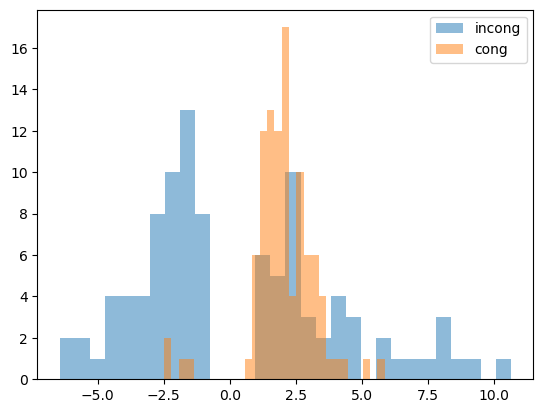

In [ ]:
fig, axes = plt.subplots(1,1)
axes.hist(x1[0].reshape(-1), bins=30, alpha=0.5, label='incong')
axes.hist(x2[0].reshape(-1), bins=30, alpha=0.5, label='cong')
axes.legend()
plt.show()

In [ ]:
priors = DDM.prior(10)
x = DDM.batch_simulator(priors, 100)

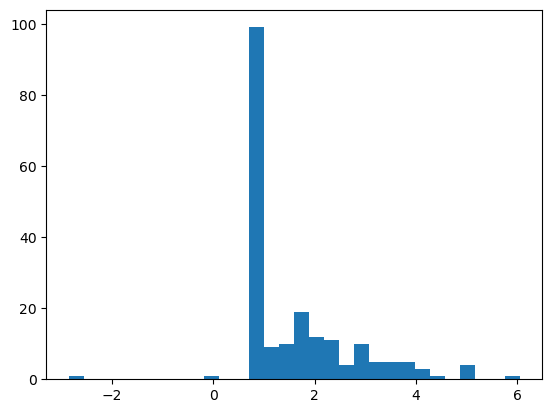

In [ ]:
fig, axes = plt.subplots(1,1)
axes.hist(x[0].reshape(-1), bins=30)
plt.show()

### Unvertainty

In [ ]:
list_acc = []
n_nobs = 50
for n in np.arange(1,1000, step=1):
    params, data = DistributionDataset.sample_Normal(n_prior=n_nobs, n_obs=n)
    pre = evidential_net.predict(summary_net(data.to(device).unsqueeze(dim=-1)), to_numpy=False)
    list_acc.append((pre['m_probs'].argmax(dim=1)==0).sum().item()/n_nobs)

In [ ]:
plt.plot(np.arange(1,1000, step=1), list_acc)
plt.ylabel('acc')
plt.xlabel('n_observation')
plt.title('acc - n_observation')
plt.show()

### Accuracy

# flanker dataset

## load dataset

In [7]:
experimental_settings = ['Subject', 'Coherence', 'Spacing', 'Congruency']

In [8]:
def load_dataset():
    folder = r'C:\Users\Chen\Documents\Projects\FlowParamEstim\FlowParamEstim_RT\FlankerCSV'
    files_dataset = os.listdir(folder)
    columns = ['Subject', 'Trial', 'Coherence', 'Practice', 'Block', 'Target_Direction', 'RT', 'Acc', 'Congruency', 'Spacing']
    data = pd.DataFrame(columns=columns)

    for file_name in files_dataset:
        df = pd.read_csv(os.path.join(folder, file_name))
        df['Subject'] = file_name.split('.')[0]
        if 'N' in file_name:
            df['Spacing'] = 'Narrow'
        else:
            df['Spacing'] = 'Wide'
        # data = data.append(df[columns])
        data = pd.concat([data, df[columns]])

    data = data[data['Practice'] == 0]
    data.loc[data['Acc']==0, 'RT'] = -data.loc[data['Acc']==0, 'RT']
    data.loc[:, 'Congruency'] = 1 - data.loc[:, 'Congruency']
    data = data.reset_index(drop=True)

    return data

In [9]:
data = load_dataset()


In [28]:
def select_dataset(data, subject, coherence, spacing, congruency):

    df_samp = data.loc[data['Subject']==subject].loc[data['Coherence']==coherence] \
        .loc[data['Spacing']==spacing].loc[data['Congruency']==congruency]
    return df_samp[['RT', 'Congruency']].to_numpy()

def divide_dataset(data):
    # output: array(batch, n_obs, data(options: 0/1, RTs: float)), 
    # where 1 means correct options, 0 means incorrect option.
    subjects = list(set(data['Subject']))
    coherences = list(set(data['Coherence']))
    spacings = list(set(data['Spacing']))
    congruences = list(set(data['Congruency']))
    coherences.sort()

    indexes = []
    data_array = []
    for subject in subjects:
        for coherence in coherences:
            for spacing in spacings:
                for congruency in congruences:
                    array = select_dataset(data, subject, coherence, spacing, congruency)
                    if array.shape[0] != 0:
                        indexes.append((subject, coherence, spacing, congruency))
                        data_array.append(array)

    data_array = np.stack(data_array, axis=0).astype(np.float32)  
    data_array[data_array[:,:,0]>10, 0] = 10    
    data_array[data_array[:,:,0]<-10, 0] = -10   
    # data_array = data_array[:, 1:, :]
    indexes = pd.DataFrame(indexes, columns=experimental_settings)
    indexes.loc[indexes['Congruency']==1, 'Congruency'] = 'Incongruency'
    indexes.loc[indexes['Congruency']==0, 'Congruency'] = 'Congruency'
    return indexes, data_array


In [29]:
indexes, data_array = divide_dataset(data)

In [21]:
x = torch.from_numpy(data_array[:,:,:1]).to(device)
gt = torch.from_numpy(data_array[:,0,1]).to(device)

In [13]:
alphas = evidential_net.predict(summary_net(x), to_numpy=False)

In [25]:
acc = (alphas['m_probs'].argmax(dim=1)==gt)
acc.float().mean()

tensor(0.5000, device='cuda:0')

## visualization

In [30]:
indexes['Congruency'] == 'Congruency'

0       True
1      False
2       True
3      False
4       True
       ...  
403    False
404     True
405    False
406     True
407    False
Name: Congruency, Length: 408, dtype: bool

In [31]:
indexes

,Subject,Coherence,Spacing,Congruency
0,N20,10,Narrow,Congruency
1,N20,10,Narrow,Incongruency
2,N20,20,Narrow,Congruency
3,N20,20,Narrow,Incongruency
4,N20,40,Narrow,Congruency
...,...,...,...,...
403,N17,60,Narrow,Incongruency
404,N17,80,Narrow,Congruency
405,N17,80,Narrow,Incongruency
406,N17,90,Narrow,Congruency
